In [ ]:
__author__ = 'Benjamin Weaver <benjamin.weaver@noirlab.edu>, Alice Jacques <alice.jacques@noirlab.edu>, Astro Data Lab Team <datalab@noirlab.edu>'
__version__ = '20230616'
__datasets__ = ['desi_edr']
__keywords__ = ['query', 'DESI']

# How to Query DESI EDR Data

## Table of Contents

* [Goals](#Goals)
* [Summary](#Summary)
* [Disclaimer and Attribution](#Disclaimer-and-Attribution)
* [Initial Setup](#Initial-Setup)
* [Contents of the Database](#Contents-of-the-Database)
* [Authentication](#Authentication)
* [Simple Queries](#Simple-Queries)
* [Joining Tables](#Joining-Tables)
* [Matching Redshift Tables to Targeting Data](#Matching-Redshift-Tables-to-Targeting-Data)
* [Survey Progress](#Survey-Progress)
* [Using q3c](#Using-q3c)
* [Resources and References](#Resources-and-References)

## Goals

Demonstrate a variety of queries using the `desi_edr` data set.

## Summary

This notebook will cover the basics of using the DESI spectroscopic production database, `desi_edr`, which is loaded from the outputs of the DESI pipeline. This notebook is intended to cover as much of the detail of DESI's [introductory notebook tutorial](https://github.com/desihub/tutorials/blob/main/database/spectroscopic-production-database.ipynb) as possible, although rewritten for the Data Lab environment. For more details, including detailed table descriptions see DESI's [database access page](https://data.desi.lbl.gov/doc/access/database/).

## Disclaimer and Attribution

If you use this notebook for your published science, please acknowledge the following:

* DESI Data citation and acknowledgments: https://data.desi.lbl.gov/doc/acknowledgments/
* Data Lab concept paper: Fitzpatrick *et al.*, "The NOAO Data Laboratory: a conceptual overview", SPIE, **9149**, 2014, http://dx.doi.org/10.1117/12.2057445
* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

## Initial Setup

This just imports everything we need and sets up paths and environment variables so we can find things.

In [1]:
#
# Imports
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from dl import queryClient as qc, authClient as ac
#
# DESI software
#
from desitarget import __version__ as desitarget_version
from desitarget.targetmask import desi_mask
#
print(f"desitarget=={desitarget_version}")

desitarget==2.6.0


## Contents of the Database

### Schema

All tables are grouped into the `desi_edr` database schema.

### Important notes

* This database does not contain any sky spectra. Both deliberately-targeted (`targetid & 2**59 != 0`) and negative targetid (`targetid < 0`) sky spectra are excluded.
* Only quantities derived from *cumulative* tile-based spectra are included at the present time.

### The tables

* `photometry`. This contains the pure photometric data. Usually this is derived from the LS DR9 Tractor data, but not every *targeted* object has Tractor photometry.
  - Loaded from `tractorphot` files in the [lsdr9-photometry VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/lsdr9-photometry/): `/global/cfs/cdirs/desi/public/edr/vac/edr/lsdr9-photometry/fuji/v2.1/potential-targets/tractorphot/tractorphot-potential-*-fuji.fits`, https://data.desi.lbl.gov/public/edr/vac/edr/lsdr9-photometry/fuji/v2.1/potential-targets/tractorphot/
  - Primary key: `targetid`.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#photometry).
* `target`. This contains the targeting bits and other data generated by `desitarget`.
  - Loaded from `targetphot` file in the [lsdr9-photometry VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/lsdr9-photometry/): `/global/cfs/cdirs/desi/public/edr/vac/edr/lsdr9-photometry/fuji/v2.1/potential-targets/targetphot-potential-fuji.fits`, https://data.desi.lbl.gov/public/edr/vac/edr/lsdr9-photometry/fuji/v2.1/potential-targets/targetphot-potential-fuji.fits
  - Unique identifier: (`targetid`, `survey`, `tileid`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `survey`, `tileid`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#target).
* `tile`. This contains information about observations grouped by tile.
  - Loaded from top-level `tiles-fuji.fits`, https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/tiles-fuji.fits
  - Primary key: `tileid`.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#tile).
* `exposure`. This contains information about individual exposures.
  - Loaded from top-level `exposures-fuji.fits` https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/exposures-fuji.fits, `EXPOSURES` HDU.
  - Primary key: `expid`.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#exposure).
* `frame`. This contains information about individual exposures, but broken down by camera.  There will usually, but not always, be 30 frames per exposure.
  - Loaded from top-level `exposures-fuji.fits`, https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/exposures-fuji.fits, `FRAMES` HDU.
  - Unique identifier: (`expid`, `camera`).
  - Primary key: `frameid`, composed from `expid` and a mapping of `camera` to an arbitrary integer.
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#frame).
* `fiberassign`. This contains information about fiber positions.
  - Loaded from fiberassign files in the [tiles product](https://data.desi.lbl.gov/public/edr/target/fiberassign/tiles/tags/0.5/).  All fiberassign files corresponding to tiles in the `tile` table are loaded.
  - Unique identifier: (`tileid`, `targetid`, `location`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`tileid`, `targetid`, `location`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#fiberassign).
* `potential`. This contains a list of `targetid`s that *could* have been targeted on a given tile.
  - Loaded from the `POTENTIAL_ASSIGNMENTS` HDU in the same fiberassign files mentioned above.
  - Unique identifier: (`tileid`, `targetid`, `location`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`tileid`, `targetid`, `location`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#potential).
* `zpix`. This contains the pipeline redshifts grouped by HEALPixel.
  - Loaded from the [zcat VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/zcat/): `/global/cfs/cdirs/desi/public/edr/vac/edr/zcat/fuji/v1.0/zall-pix-edr-vac.fits`, https://data.desi.lbl.gov/public/edr/vac/edr/zcat/fuji/v1.0/zall-pix-edr-vac.fits
  - Based on the `zall-pix-fuji.fits` file in the `zcatalog/` directory.
  - Unique identifier: (`targetid`, `survey`, `program`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `survey`, `program`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#zpix).
* `ztile`. This contains the pipeline redshifts grouped by tile in a variety of ways.
  - Loaded from the [zcat VAC](https://data.desi.lbl.gov/doc/releases/edr/vac/zcat/): `/global/cfs/cdirs/desi/public/edr/vac/edr/zcat/fuji/v1.0/zall-tilecumulative-edr-vac.fits`, https://data.desi.lbl.gov/public/edr/vac/edr/zcat/fuji/v1.0/zall-tilecumulative-edr-vac.fits
  - Based on the `zall-tilecumulative-fuji.fits` file in the `zcatalog/` directory.
  - Unique identifier: (`targetid`, `spgrp`, `spgrpval`, `tileid`).
  - Primary key: `id`, a unique, arbitrary integer composed from (`targetid`, `spgrp`, `spgrpval`, `tileid`).
  - [Column descriptions](https://data.desi.lbl.gov/doc/access/database/#ztile).

### Foreign key relationships

* `desi_edr.target.targetid` -> `desi_edr.photometry.targetid`.
* `desi_edr.target.tileid` -> `desi_edr.tile.tileid`.
* `desi_edr.exposure.tileid` -> `desi_edr.tile.tileid`.
* `desi_edr.frame.expid` -> `desi_edr.exposure.expid`.
* `desi_edr.fiberassign.targetid` -> `desi_edr.photometry.targetid`.
* `desi_edr.fiberassign.tileid` -> `desi_edr.tile.tileid`.
* `desi_edr.potential.targetid` -> `desi_edr.photometry.targetid`.
* `desi_edr.potential.tileid` -> `desi_edr.tile.tileid`.
* `desi_edr.zpix.targetid` -> `desi_edr.photometry.targetid`.
* `desi_edr.ztile.targetphotid` -> `desi_edr.target.id`.
* `desi_edr.ztile.targetid` -> `desi_edr.photometry.targetid`.
* `desi_edr.ztile.tileid` -> `desi_edr.tile.tileid`.

## Authentication

Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (*i.e.* you will need a registered user account).

If you need to log in to Data Lab, issue this command, and respond according to the instructions:

In [2]:
# ac.login(input("Enter user name: (+ENTER) "), getpass("Enter password: (+ENTER) "))
# ac.whoAmI()

## Simple Queries

In most of the examples below, we include the equivalent raw SQL command that corresponds to the query.

### Exposures, Nights, Tiles

Here are some simple queries that demonstrate simple connections between nights, exposures and tiles.

#### How many tiles are there?

```SQL
SELECT COUNT(tileid) FROM desi_edr.tile;
```

In [3]:
response = qc.query(sql='SELECT COUNT(tileid) FROM desi_edr.tile;', fmt='pandas', timeout=600)
response

,count
0,732


#### On which nights were a particular tile observed?

```SQL
SELECT night, expid FROM desi_edr.exposure WHERE tileid = 100;
```

In [4]:
response = qc.query(sql='SELECT night, expid FROM desi_edr.exposure WHERE tileid = 100;', fmt='pandas', timeout=600)
response

,night,expid
0,20210504,87236
1,20210505,87361


#### Which tiles were observed on a night?

```SQL
SELECT tileid, survey, program FROM desi_edr.exposure WHERE night = 20210115;
```

In [5]:
response = qc.query(sql='SELECT tileid, survey, program FROM desi_edr.exposure WHERE night = 20210115;', fmt='pandas', timeout=600)
response

,tileid,survey,program
0,80655,sv1,bright
1,80680,sv1,dark
2,80680,sv1,dark
3,80660,sv1,bright
4,80660,sv1,bright
5,80715,sv1,other
6,80715,sv1,other
7,80715,sv1,other
8,80674,sv1,dark
9,80674,sv1,dark


### Select ELG Targets

Here's a simple demonstration of finding specific targets using the target bitmask values. In this case `desi_mask.ELG == 2**1`.

```SQL
SELECT * from desi_edr.target WHERE (desi_target & 2) != 0;
```

In [6]:
q = f"SELECT * FROM desi_edr.target WHERE (desi_target & {desi_mask.ELG:d}) != 0 LIMIT 10;"
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,id,subpriority,targetid,obsconditions,priority_init,numobs_init,hpxpixel,cmx_target,desi_target,bgs_target,...,sv3_mws_target,scnd_target,sv1_scnd_target,sv2_scnd_target,sv3_scnd_target,random_id,tileid,photsys,program,survey
0,158457821059512681299414356074,0.114412,39628267690397802,1,3200,2,27991,0,655458,0,...,0,0,0,0,0,90.878240,81100,S,dark,special
1,158457821059512681299414355923,0.528283,39628267690397651,1,3100,2,27991,0,655394,0,...,0,0,0,0,0,15.062133,81100,S,dark,special
2,158457821059512681305047305049,0.830456,39628273323346777,1,3200,2,27998,0,720931,0,...,0,0,0,0,0,83.891140,81100,S,dark,special
3,158457821059512681305047305350,0.105351,39628273323347078,1,3100,2,27998,0,655394,0,...,0,0,0,0,0,13.898089,81100,S,dark,special
4,158457821059512681299422744039,0.834181,39628267698785767,1,3100,2,27991,0,655394,0,...,0,0,0,0,0,33.033150,81100,S,dark,special
5,158457821059512681305047302452,0.842228,39628273323344180,1,3100,2,27995,0,655394,0,...,0,0,0,0,0,24.432514,81100,S,dark,special
6,158457821059512681299401769082,0.542252,39628267677810810,1,3100,2,27996,0,655394,0,...,0,0,0,0,0,52.833660,81100,S,dark,special
7,158457821059512681299405964738,0.737797,39628267682006466,1,3100,2,27996,0,655394,0,...,0,0,0,0,0,69.306915,81100,S,dark,special
8,158457821059512681299405964706,0.776134,39628267682006434,1,3100,2,27997,0,655394,0,...,0,0,0,0,0,16.220716,81100,S,dark,special
9,158457821059512681299405964512,0.458798,39628267682006240,1,3100,2,27996,0,655394,0,...,0,0,0,0,0,53.209180,81100,S,dark,special


#### Exercise

* How many objects in the `zpix` table have `spectype` 'GALAXY'?

### Redshift and Classification

Simple query filtering on string values. There are a lot of stars, so this query has a `LIMIT 20`.

```SQL
SELECT spectype, subtype, z FROM desi_edr.zpix WHERE spectype = 'STAR' AND subtype != '' LIMIT 20;
```

In [7]:
response = qc.query(sql="SELECT spectype, subtype, z FROM desi_edr.zpix WHERE spectype = 'STAR' AND subtype != '' LIMIT 20;", fmt='pandas', timeout=600)
response

,spectype,subtype,z
0,STAR,K,0.000025
1,STAR,K,-0.000087
2,STAR,K,-0.000402
3,STAR,K,-0.000093
4,STAR,K,-0.000187
5,STAR,G,-0.000132
6,STAR,K,-0.000074
7,STAR,G,-0.000237
8,STAR,G,-0.000164
9,STAR,M,-0.000067


## Joining Tables

### A Simple Join

Let's look at the nights and exposures on which a particular `TARGETID` was observed.

```SQL
SELECT f.tileid, e.expid, e.night FROM desi_edr.fiberassign AS f JOIN desi_edr.exposure AS e ON f.tileid = e.tileid WHERE f.targetid = 933811403620352;
```

In [8]:
q = """SELECT f.tileid, e.expid, e.night
FROM desi_edr.fiberassign AS f
JOIN desi_edr.exposure AS e ON f.tileid = e.tileid
WHERE f.targetid = 933811403620352;"""
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,tileid,expid,night
0,278,85086,20210416
1,279,85209,20210417
2,279,85207,20210417
3,279,85206,20210417
4,279,85208,20210417
5,280,86981,20210502
6,280,86980,20210502


### Another Simple Join

In this case, we'll look at photometric flux and measured redshift. We'll `ORDER`(`BY`) the results and `LIMIT` the query to keep the numbers manageable.

```SQL
SELECT p.*, z.* FROM desi_edr.photometry AS p JOIN desi_edr.zpix AS z ON p.targetid = z.targetid ORDER BY z.z, p.flux_g LIMIT 50;
```

In [9]:
q = """SELECT p.*, z.*
FROM desi_edr.photometry AS p
JOIN desi_edr.zpix AS z ON p.targetid = z.targetid
ORDER BY z.z, p.flux_g LIMIT 50;"""
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,ra,dec,elon,elat,glon,glat,ls_id,ref_id,targetid,ra_ivar,...,coadd_numnight,coadd_numtile,sv_nspec,main_nspec,zcat_nspec,spgrp,subtype,program,spectype,survey
0,242.669697,55.553265,207.119848,73.035716,85.645425,44.498546,0,0,222434603040803,0.000000e+00,...,5,1,1,0,1,healpix,NaN,other,GALAXY,sv1
1,224.447662,52.087582,190.455221,63.508803,88.154778,55.647563,0,0,103636998815828,0.000000e+00,...,3,1,1,0,1,healpix,NaN,other,GALAXY,sv1
2,165.134033,51.221375,142.918060,40.641631,156.385340,58.090624,0,0,103625095381015,0.000000e+00,...,4,1,1,0,1,healpix,NaN,other,GALAXY,sv1
3,149.240285,2.478937,150.486017,-9.413900,235.843639,41.561073,9906622400041930,0,234545026695170,4.202756e+09,...,4,1,1,0,1,healpix,NaN,other,GALAXY,sv1
4,192.238997,29.758244,178.070262,31.910169,134.504809,87.314033,9906632213006951,0,39628475656571495,3.065923e+09,...,1,1,0,0,1,healpix,NaN,dark,GALAXY,special
5,220.429917,-1.018725,218.342491,13.981739,350.707977,51.323935,9906621097513700,0,39627764264866532,1.043706e+10,...,2,2,1,0,1,healpix,NaN,dark,GALAXY,sv3
6,210.890279,4.739193,207.042597,16.219714,343.636056,61.770632,9906623264523405,0,39627902953718925,1.030241e+10,...,2,2,1,0,1,healpix,NaN,dark,GALAXY,sv3
7,251.791031,35.433424,242.032555,57.118047,57.851161,39.686266,9907733568555419,0,39632991714019739,8.444424e+09,...,2,2,1,0,1,healpix,NaN,dark,GALAXY,sv3
8,188.194869,57.133013,153.901093,53.263362,127.967207,59.812453,9907739203996548,0,39633352382221188,9.182881e+09,...,1,1,1,0,1,healpix,NaN,dark,GALAXY,sv2
9,235.187267,42.490985,214.262582,59.378746,68.310172,52.483996,9907735621861878,0,39633123125756406,1.108334e+10,...,3,3,1,0,1,healpix,NaN,dark,GALAXY,sv3


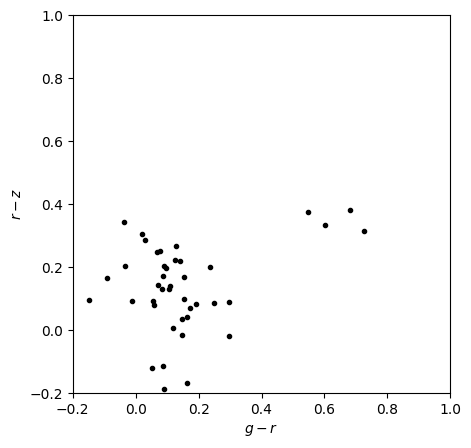

In [10]:
# Avoid warnings about invalid values in np.log10().
w = (response.flux_g.values > 0) & (response.flux_r.values > 0)
g_minus_r = np.log10(response.flux_r.values[w]/response.flux_g.values[w])
r_minus_z = np.log10(response.flux_z.values[w]/response.flux_r.values[w])
redshift = np.array(response.z.values[w])
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
p = axes.plot(g_minus_r, r_minus_z, 'k.')
foo = axes.set_xlim([-0.2, 1.0])
foo = axes.set_ylim([-0.2, 1.0])
foo = axes.set_aspect('equal')
foo = axes.set_xlabel('$g - r$')
foo = axes.set_ylabel('$r - z$')

#### Exercise

* Create a color-color plot for objects targeted as QSOs, and spectroscopically confirmed as such.

### A More Complicated Join

Let's look at objects that appear on more than one tile. For each of those tiles, how many exposures where there?

In this example, we're using a subquery that itself is a multi-table join.

```SQL
SELECT t.nexp, f.tileid, q1.targetid, q1.n_assign FROM desi_edr.fiberassign AS f
    JOIN (SELECT ff.targetid, COUNT(*) AS n_assign FROM desi_edr.fiberassign AS ff GROUP BY ff.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN desi_edr.tile AS t ON f.tileid = t.tileid LIMIT 100;
```

In [11]:
q = """SELECT t.nexp, f.tileid, q1.targetid, q1.n_assign
FROM desi_edr.fiberassign AS f
JOIN (SELECT ff.targetid, COUNT(*) AS n_assign FROM desi_edr.fiberassign AS ff GROUP BY ff.targetid) AS q1 ON f.targetid = q1.targetid
JOIN desi_edr.tile AS t ON f.tileid = t.tileid LIMIT 100;
"""
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,nexp,tileid,targetid,n_assign
0,7,80856,6432023904256,1
1,7,80856,6448025174016,1
2,2,80875,6515536691200,2
3,3,80876,6515536691200,2
4,4,80889,6521555517440,2
...,...,...,...,...
95,3,80715,28684329156667,1
96,3,80715,28684333350912,1
97,3,80715,28684333350916,1
98,3,80715,28684333350917,1


Now let's see what the redshift table thinks are the number of exposures for these objects.

```SQL
SELECT z.* FROM desi_edr.zpix AS z WHERE z.targetid IN (6432023904256, 6448025174016[, ...]);
```

In [12]:
q3 = """SELECT z.* FROM desi_edr.zpix AS z
WHERE z.targetid IN ({0});
""".format(', '.join(map(str, response.targetid.values.tolist())))
response3 = qc.query(sql=q3, fmt='pandas', timeout=600)
response3

,id,elon,elat,glon,glat,z,zerr,chi2,coeff_0,coeff_1,...,coadd_numnight,coadd_numtile,sv_nspec,main_nspec,zcat_nspec,spgrp,subtype,program,spectype,survey
0,237684487598133251433784410112,167.730104,25.008653,207.210127,78.086246,-0.001996,4.131149e-48,9.000000e+99,0.000000,0.000000,...,0,0,1,0,1,healpix,CV,dark,STAR,sv1
1,237684487598133251449785679872,167.111587,25.566486,203.657986,77.813752,0.022191,9.449554e-06,8.750537e+03,-50.889806,-75.544294,...,4,1,1,0,1,healpix,NaN,dark,GALAXY,sv1
2,237684487598133251517297197056,134.942701,16.270087,194.248493,46.670288,0.536407,9.685293e-05,8.898141e+03,0.000000,0.000000,...,1,2,1,0,1,healpix,NaN,dark,GALAXY,sv1
3,237684487598133251523316023296,187.929756,38.738369,62.348442,78.947916,0.010018,1.945738e-05,8.524950e+03,147.422851,448.971083,...,3,2,1,0,1,healpix,NaN,dark,GALAXY,sv1
4,237684487598133251538398740480,171.051217,32.285289,166.261505,81.928293,0.076412,9.202725e-06,8.079056e+03,0.000000,0.000000,...,2,2,1,0,1,healpix,NaN,dark,GALAXY,sv1
5,237684487598133251547793981440,125.943924,14.897709,190.679506,38.296622,1.040803,1.445926e-04,9.177329e+03,152.471145,81.142716,...,4,1,1,0,1,healpix,NaN,dark,GALAXY,sv1
6,316912650112397611279616835587,26.481537,33.672771,119.915621,-21.765709,-0.000515,3.859789e-06,9.021039e+03,0.000000,0.000000,...,1,1,1,0,1,healpix,G,other,STAR,sv1
7,316912650112397611279616835588,26.320239,33.653706,119.792606,-21.838792,0.188360,2.404085e-05,9.444794e+03,74.557410,-8.310338,...,1,1,1,0,1,healpix,NaN,other,GALAXY,sv1
8,316912650112397611279621029889,26.651447,33.535369,120.115906,-21.831460,0.080796,1.011449e-05,1.105564e+04,0.000017,0.000117,...,1,1,1,0,1,healpix,NaN,other,GALAXY,sv1


#### Exercise

* What is the distribution of number of exposures?

## Matching Redshift Tables to Targeting Data

Matching redshift results back to targeting is an important task for many DESI science projects. Below we briefly describe the fundamentals of this matching using the database.

### Tile-based

The `ztile` table contains a foreign key pointing to the primary key of the `target` table. This means that for any row of `ztile`, there is a pre-matched entry in the `target` table, and it can be accessed with a simple join, such as:
```SQL
SELECT z.targetid, z.spgrp, z.spgrpval, z.tileid, z.z, z.zwarn, z.spectype,
    t.sv1_desi_target, t.sv1_bgs_target, t.sv1_mws_target, t.sv1_scnd_target,
    p.ra, p.dec
FROM desi_edr.ztile AS z
JOIN desi_edr.target AS t ON z.targetphotid = t.id
JOIN desi_edr.photometry AS p ON z.targetid = p.targetid
LIMIT 50;
```
Note the `z.targetphotid = t.id`. This query also demonstrates a JOIN with the `photometry` table, where `targetid` is unique.

In [13]:
q = """SELECT z.targetid, z.spgrp, z.spgrpval, z.tileid, z.z, z.zwarn, z.spectype,
    t.sv1_desi_target, t.sv1_bgs_target, t.sv1_mws_target, t.sv1_scnd_target,
    p.ra, p.dec
FROM desi_edr.ztile AS z
JOIN desi_edr.target AS t ON z.targetphotid = t.id
JOIN desi_edr.photometry AS p ON z.targetid = p.targetid
LIMIT 50;"""
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,targetid,spgrp,spgrpval,tileid,z,zwarn,spectype,sv1_desi_target,sv1_bgs_target,sv1_mws_target,sv1_scnd_target,ra,dec
0,39628473198708395,cumulative,20201216,80615,-0.001996,1570,STAR,0,0,0,0,23.661968,29.847589
1,39628473198709499,cumulative,20201216,80615,0.797663,0,GALAXY,0,0,0,0,23.711764,29.843727
2,39628473198710139,cumulative,20201216,80615,1.331505,0,GALAXY,0,0,0,0,23.742629,29.874941
3,39628473198710603,cumulative,20201216,80615,0.804206,0,GALAXY,0,0,0,0,23.764862,29.832379
4,39628473198711006,cumulative,20201216,80615,-0.000066,0,STAR,0,0,0,0,23.786493,29.866736
5,39628473198711342,cumulative,20201216,80615,-0.001996,1570,STAR,0,0,0,0,23.802207,29.832150
6,39628473198711925,cumulative,20201216,80615,0.390724,0,GALAXY,0,0,0,0,23.832176,29.858176
7,39628473202901028,cumulative,20201216,80615,0.665800,0,GALAXY,0,0,0,0,23.866668,29.816397
8,39628473202901626,cumulative,20201216,80615,0.328420,0,GALAXY,0,0,0,0,23.898508,29.849485
9,39628473202901945,cumulative,20201216,80615,0.354993,0,GALAXY,0,0,0,0,23.915474,29.800489


### HEALPixel-based

The redshift results from HEALPixel-based coadds in the `zpix` table may be made up of several tiles, so it is not as simple to match these with targeting data. In the majority of cases, the targeting information is the same for a `targetid` across multiple tiles, as long as the tiles are part of the same survey (*e.g.* `sv1`). However it is not *always* the case, so we have instead collected the best values of the targeting information and placed those values directly in the `zpix` table. Here is the analogous query to the query above:
```SQL
SELECT z.targetid, z.survey, z.program, z.healpix, z.z, z.zwarn, z.spectype,
    z.sv1_desi_target, z.sv1_bgs_target, z.sv1_mws_target, z.sv1_scnd_target,
    p.ra, p.dec
FROM desi_edr.zpix AS z
JOIN desi_edr.photometry AS p ON z.targetid = p.targetid
LIMIT 50;
```
If you wish to explore this issue in more detail, there is an [example notebook](https://github.com/desihub/specprod-db/blob/main/doc/nb/finding-edge-cases.ipynb) (*note*: this example notebook is intended for use at [NERSC](https://www.nersc.gov)).

In [14]:
q = """SELECT z.targetid, z.survey, z.program, z.healpix, z.z, z.zwarn, z.spectype,
    z.sv1_desi_target, z.sv1_bgs_target, z.sv1_mws_target, z.sv1_scnd_target,
    p.ra, p.dec
FROM desi_edr.zpix AS z
JOIN desi_edr.photometry AS p ON z.targetid = p.targetid
LIMIT 50;"""
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,targetid,survey,program,healpix,z,zwarn,spectype,sv1_desi_target,sv1_bgs_target,sv1_mws_target,sv1_scnd_target,ra,dec
0,6432023904256,sv1,dark,28473,-0.001996,1570,STAR,4611686018427387904,0,0,2,179.444160,27.658900
1,6448025174016,sv1,dark,28478,0.022191,0,GALAXY,4611686018427387904,0,0,2,179.156570,28.423480
2,6515536691200,sv1,dark,4958,0.536407,4,GALAXY,4611686018427387904,0,0,2,142.948110,31.824780
3,6521555517440,sv1,dark,10436,0.010018,0,GALAXY,4611686018427387904,0,0,2,204.227490,32.094930
4,6536638234624,sv1,dark,28534,0.076412,0,GALAXY,4611686018427387904,0,0,2,186.274119,32.845030
5,6546033475584,sv1,dark,5066,1.040803,4,GALAXY,4611686018427387904,0,0,2,132.662110,33.167730
6,28684312379395,sv1,other,2708,-0.000515,0,STAR,4611686018427387904,0,0,64,9.145797,41.019015
7,28684312379396,sv1,other,2707,0.188360,0,GALAXY,4611686018427387904,0,0,64,9.000947,40.938849
8,28684316573697,sv1,other,2708,0.080796,0,GALAXY,4611686018427387904,0,0,64,9.396960,40.964540
9,28688884170754,sv1,other,2710,0.190204,0,GALAXY,4611686018427387904,0,0,64,9.132197,41.194937


## Survey Progress

Let's see which nights have data, and count the number of exposures per night.

```SQL
SELECT e.night, COUNT(e.expid) AS n_exp FROM desi_edr.exposure AS e GROUP BY e.night ORDER BY e.night;
```

In [15]:
q = "SELECT e.night, COUNT(e.expid) AS n_exp FROM desi_edr.exposure AS e GROUP BY e.night ORDER BY e.night;"
night_exposures = qc.query(sql=q, fmt='pandas', timeout=600)
night_exposures

,night,n_exp
0,20201214,17
1,20201215,23
2,20201216,24
3,20201217,7
4,20201218,27
...,...,...
103,20210517,3
104,20210518,3
105,20210521,1
106,20210529,16


Observation timestamp for a given night.  Note how we have both MJD and a corresponding `datetime.datetime` object in the database.

```SQL
SELECT e.expid, e.mjd, e.date_obs FROM desi_edr.exposure AS e WHERE e.night = 20210428 ORDER BY e.expid;
```

In [16]:
q = "SELECT e.expid, e.mjd, e.date_obs FROM desi_edr.exposure AS e WHERE e.night = 20210428 ORDER BY e.expid;"
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,expid,mjd,date_obs
0,86493,59333.216755,2021-04-28 22:12:07.607808-07
1,86494,59333.223580,2021-04-28 22:21:57.3336-07
2,86495,59333.231531,2021-04-28 22:33:24.31296-07
3,86503,59333.309867,2021-04-29 00:26:12.514848-07
4,86504,59333.327059,2021-04-29 00:50:57.902784-07
5,86505,59333.331919,2021-04-29 00:57:57.783456-07
6,86507,59333.379902,2021-04-29 02:07:03.564768-07
7,86508,59333.386287,2021-04-29 02:16:15.176064-07
8,86509,59333.392383,2021-04-29 02:25:01.863552-07
9,86511,59333.402576,2021-04-29 02:39:42.52752-07


So, for a given target in the `target` table, when was the observation completed?  In other words, if a target has multiple observations, we want the date of the *last* observation.  First, how many targets are there?

```SQL
SELECT COUNT(*) AS n_targets FROM desi_edr.target;
```

In [17]:
q = "SELECT COUNT(*) AS n_targets FROM desi_edr.target;"
N_targets = qc.query(sql=q, fmt='pandas', timeout=600)
N_targets

,n_targets
0,16460561


Now we look for targets that have observations and find the MJD of the observation.

```SQL
SELECT f.targetid, e.expid, e.mjd FROM desi_edr.fiberassign AS f
    JOIN (SELECT tt.targetid FROM desi_edr.target AS tt JOIN desi_edr.fiberassign AS ff ON tt.targetid = ff.targetid
              JOIN desi_edr.exposure AS ee ON ff.tileid = ee.tileid GROUP BY tt.targetid) AS q1 ON f.targetid = q1.targetid
    JOIN desi_edr.exposure AS e ON f.tileid = e.tileid ORDER BY q1.targetid, e.expid;
```

In [18]:
%%time
# This will run for ~1 minute
#
# Find all targetids that have observations.
#
q1 = """SELECT tt.targetid FROM desi_edr.target AS tt JOIN desi_edr.fiberassign AS ff ON tt.targetid = ff.targetid
    JOIN desi_edr.exposure AS ee ON ff.tileid = ee.tileid GROUP BY tt.targetid"""
#
# Find the exposure times for the targetids that have been observed
#
q2 = f"""SELECT f.targetid, e.expid, e.mjd FROM desi_edr.fiberassign AS f
    JOIN ({q1}) AS q1 ON f.targetid = q1.targetid
    JOIN desi_edr.exposure AS e ON f.tileid = e.tileid ORDER BY q1.targetid, e.expid;"""
response = qc.query(sql=q2, fmt='pandas', timeout=600)
targetid = response.targetid.values
expid = response.expid.values
mjd = response.mjd.values
#
# Use the counts to give the *last* observation.
#
unique_targetid, i, j, c = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
unique_expid = expid[i + (c-1)]
unique_mjd = mjd[i + (c-1)]

CPU times: user 7.65 s, sys: 5.16 s, total: 12.8 s
Wall time: 1min 50s


Now we have the targets and the date of last observation.  But it's sorted by `targetid`.

In [19]:
ii = unique_expid.argsort()
unique_targetid, i3, j3, c3 = np.unique(unique_expid[ii], return_index=True, return_inverse=True, return_counts=True)
N_completed = np.cumsum(c3)

Now we plot the fractin completed versus time.  In addition, we show the number of exposures per night.

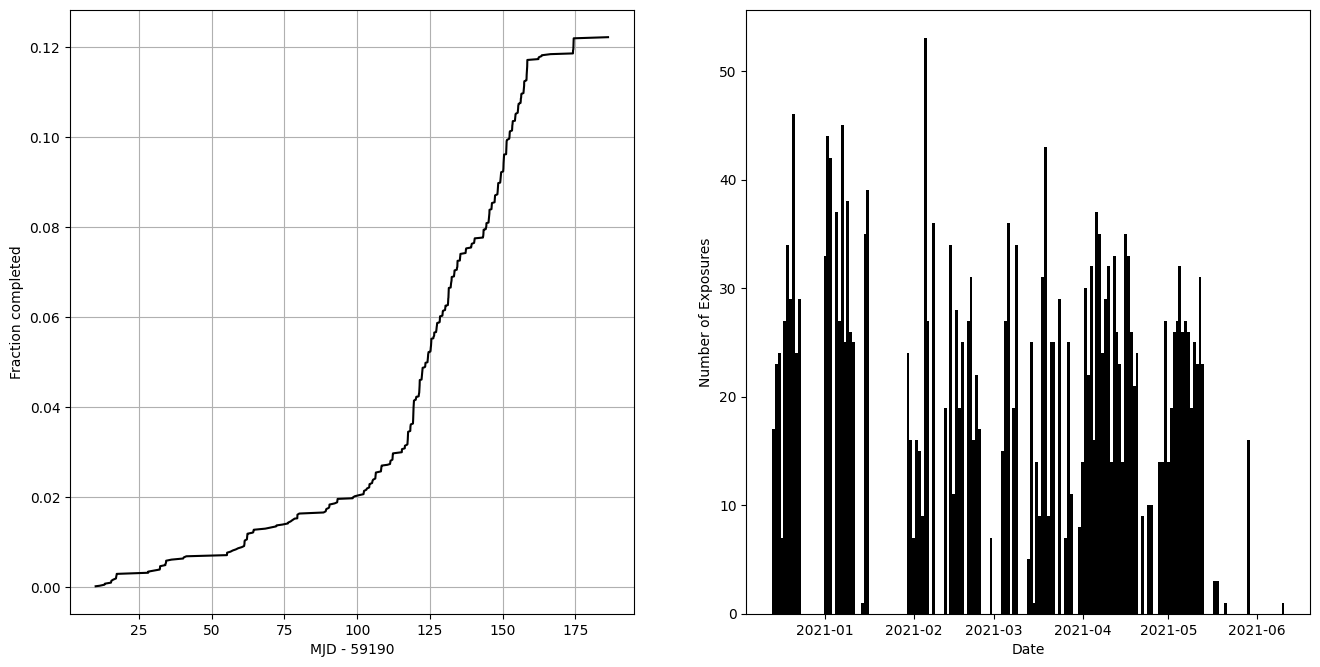

In [20]:
min_mjd = 10*(int(mjd.min())//10)
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=100)
p1 = axes[0].plot(unique_mjd[ii][i3] - min_mjd, N_completed/N_targets.n_targets.values[0], 'k-')
foo = axes[0].set_xlabel(f'MJD - {min_mjd:d}')
foo = axes[0].set_ylabel('Fraction completed')
foo = axes[0].grid(True)
foo = axes[1].bar(pd.to_datetime(night_exposures['night'],format="%Y%m%d"), night_exposures['n_exp'], color='black', width=1)   
foo = axes[1].set_xlabel('Date')
foo = axes[1].set_ylabel('Number of Exposures')

### Exercise

* Break down the progress by target class, target bit, etc.

## Using q3c

[q3c](https://github.com/segasai/q3c) ([Koposov & Bartunov 2006](https://ui.adsabs.harvard.edu/abs/2006ASPC..351..735K/abstract)) is a popular library that provides spatial indexing and searching in astronomical databases. Here we'll demonstrate how to access this functionality. This is a radial ("cone") search on an arbitrary point in the DESI footprint:

```SQL
SELECT p.*, z.*, q3c_dist(p.ra, p.dec, 180.0, 0.0) AS radial_distance
    FROM desi_edr.photometry AS p JOIN desi_edr.zpix AS z ON p.targetid = z.targetid
    WHERE q3c_radial_query(p.ra, p.dec, 180.0, 0.0, 1.0/60.0); -- 1 arcmin
```

In [21]:
q = """SELECT p.*, z.*, q3c_dist(p.ra, p.dec, 180.0, 0.0) AS radial_distance
    FROM desi_edr.photometry AS p JOIN desi_edr.zpix AS z ON p.targetid = z.targetid
    WHERE q3c_radial_query(p.ra, p.dec, 180.0, 0.0, 1.0/60.0);"""
response = qc.query(sql=q, fmt='pandas', timeout=600)
response

,ra,dec,elon,elat,glon,glat,ls_id,ref_id,targetid,ra_ivar,...,coadd_numtile,sv_nspec,main_nspec,zcat_nspec,spgrp,subtype,program,spectype,survey,radial_distance
0,179.995221,-0.014803,180.001510,-0.015482,276.340328,60.173070,9906621464385242,3602879637472757504,39627787744581338,6.673339e+11,...,1,2,0,2,healpix,NaN,dark,QSO,sv1,0.015555
1,179.995221,-0.014803,180.001510,-0.015482,276.340328,60.173070,9906621464385242,3602879637472757504,39627787744581338,6.673339e+11,...,4,2,0,2,healpix,NaN,dark,QSO,sv3,0.015555
2,179.998583,-0.016184,180.005144,-0.015412,276.347634,60.173143,9906621464385323,0,39627787744581419,2.511551e+12,...,3,1,0,1,healpix,NaN,bright,GALAXY,sv3,0.016246
3,179.985112,-0.004522,179.988146,-0.010071,276.313447,60.178470,9906621464384989,3795033274544636416,2305843037487501690,3.458816e+14,...,1,1,0,1,healpix,K,backup,STAR,sv3,0.015560
4,179.983454,-0.001613,179.985468,-0.008061,276.308058,60.180477,9906621464384944,0,39627787744581040,2.029722e+12,...,1,1,0,1,healpix,NaN,bright,GALAXY,sv3,0.016624
5,179.984545,-0.001041,179.986241,-0.007102,276.309610,60.181437,9906621464384972,3795033278840733568,39627787744581068,2.056779e+15,...,0,1,0,1,healpix,CV,bright,STAR,sv3,0.015490
6,179.998280,-0.002114,179.999270,-0.002624,276.335805,60.185927,9906621464385312,0,39627787744581408,6.774052e+11,...,1,1,0,1,healpix,NaN,bright,GALAXY,sv3,0.002726
7,180.005827,0.001174,180.004886,0.003395,276.347093,60.191950,9906621464445095,0,39627787748769959,4.643853e+09,...,4,1,0,1,healpix,NaN,dark,GALAXY,sv3,0.005944


### Exercise

* What spectra are near your favourite object?

## Resources and References

* [DESI Database Notebook](https://github.com/desihub/tutorials/blob/main/database/spectroscopic-production-database.ipynb) (*note*: requires access to [NERSC](https://www.nersc.gov)).
* [DESI Database Documentation](https://data.desi.lbl.gov/doc/access/database/).
* [DESI Early Data Release Paper](https://arxiv.org/abs/2306.06308).